# Group 8

- Trần Bình Phước - 21110079
- Lê Minh Quân - 21110792
- Trần Đức Quang - 21110793
- Lê Thụy Tường Vy - 21110114

In [23]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# Training a Classifier

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

# What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

# Training an image classifier

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>If running on Windows and you get a BrokenPipeError, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>
</div>


In [25]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 32x32 (if needed)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


batch_size = 16

print()

trainset = ImageFolder(root='./archive/Dataset/train', transform=transform)
testset = ImageFolder(root='./archive/Dataset/test', transform=transform)

batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# trainset = torchvision.datasets.CIFAR10(
#     root="./data",
#     train=True,
#     download=True,
#     transform=transform,
# )
# trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data",
#     train=False,
#     download=True,
#     transform=transform,
# )
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = (
#     "arplanes",
#     "cars",
#     "ships"
# )

classes = trainset.classes  # List of class names
print(classes)



['airplanes', 'cars', 'ship']


Let us show some of the training images, for fun.


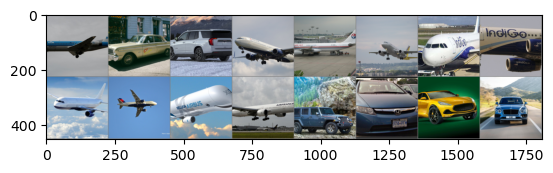

airplanes cars  cars  airplanes airplanes airplanes airplanes airplanes airplanes airplanes airplanes airplanes cars  cars  cars  cars 


In [26]:
import matplotlib.pyplot as plt
import numpy as np


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


### 2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3)
        
        # Model 1 layers
        self.model1_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Left Path
        self.model1_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.model1_conv3_left = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.model1_conv4_left = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.model1_conv5_left = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.model1_conv6_left = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)

        # Right Path
        self.model1_avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.model1_conv3_right = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        
        self.model1_final_conv = nn.Conv2d(64, 64, kernel_size=3, stride=3, padding=1)
        
        
        # Model 2 layers
        self.model2_conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        
        # Left Path
        self.model2_maxpooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.model2_conv3_left = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.model2_conv4_left = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.model2_conv5_left = nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2)

        # Right Path
        self.model2_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.model2_conv3_right = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.model2_conv4_right = nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2)
        
        # Final Conv Layer
        self.model2_final_conv = nn.Conv2d(64, 64, kernel_size=5, stride=3, padding=2)
        self.model2_avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # 38x38 -> 19x19
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 38 * 38, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        # Initial Layers
        x = nn.ReLU()(self.conv1(x))  # 224x224 -> 224x224
        
        # Model 1
        y = nn.ReLU()(self.model1_conv2(x))
        
        y1 = self.model1_avgpool1(y)
        y1_left = nn.ReLU()(self.model1_conv3_left(y1))
        y1_left = nn.ReLU()(self.model1_conv4_left(y1_left))
        y1_right = nn.ReLU()(self.model1_conv3_left(y1))
        y1_right = nn.ReLU()(self.model1_conv4_left(y1_right))
        y1= torch.cat((y1_left, y1_right), 1)
        y1= nn.ReLU()(self.model1_conv5_left(y1))
        y1= nn.ReLU()(self.model1_conv6_left(y1))
        
        y2 = self.model1_avgpool2(y)
        y2_left = nn.ReLU()(self.model1_conv3_right(y2))
        y2_right = nn.ReLU()(self.model1_conv3_right(y2))
        y2 = torch.cat((y2_left, y2_right), 1)
        
        y = torch.add(y1, y2)
        y = nn.ReLU()(self.model1_final_conv(y))


        # Model 2
        z = nn.ReLU()(self.model2_conv2(x))
        
        z1 = self.model2_maxpooling1(z)
        z1_left = nn.ReLU()(self.model2_conv3_left(z1))
        z1_left = nn.ReLU()(self.model2_conv4_left(z1_left))
        z1_right = nn.ReLU()(self.model2_conv3_left(z1))
        z1_right = nn.ReLU()(self.model2_conv4_left(z1_right))
        z1 = torch.cat((z1_left, z1_right), 1)
        z1 = nn.ReLU()(self.model2_conv5_left(z1))
        
        z2 = self.model2_maxpool2(z)
        z2_left = nn.ReLU()(self.model2_conv3_right(z2))
        z2_right = nn.ReLU()(self.model2_conv3_right(z2))
        z2 = torch.cat((z2_left, z2_right), 1)
        z2 = nn.ReLU()(self.model2_conv4_right(z2))
        
        z = torch.add(z1, z2)
        z = nn.ReLU()(self.model2_final_conv(z))

        # Combine Model 1 and Model 2
        x = torch.cat((y, z), 1)
        # x = self.maxpool(x)  # 38x38 -> 19x19
        # print(x.shape)
        # print(x.shape)
        
        # Fully Connected Layers
        x = torch.flatten(x, 1)  # Flatten for FC
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate and test the model
model = CustomCNN(num_classes=3)
# # Parameter count
# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total Parameters: {num_params / 1e6:.2f}M")

summary(model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 224, 224]        4,736
├─Conv2d: 1-2                            [-1, 64, 224, 224]        18,496
├─AvgPool2d: 1-3                         [-1, 64, 112, 112]        --
├─Conv2d: 1-4                            [-1, 64, 112, 112]        36,928
├─Conv2d: 1-5                            [-1, 32, 112, 112]        18,464
├─Conv2d: 1-6                            [-1, 64, 112, 112]        (recursive)
├─Conv2d: 1-7                            [-1, 32, 112, 112]        (recursive)
├─Conv2d: 1-8                            [-1, 128, 112, 112]       73,856
├─Conv2d: 1-9                            [-1, 64, 112, 112]        73,792
├─AvgPool2d: 1-10                        [-1, 64, 112, 112]        --
├─Conv2d: 1-11                           [-1, 32, 112, 112]        18,464
├─Conv2d: 1-12                           [-1, 32, 112, 112]        (recursive)
├─Conv2d: 1-13                 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 224, 224]        4,736
├─Conv2d: 1-2                            [-1, 64, 224, 224]        18,496
├─AvgPool2d: 1-3                         [-1, 64, 112, 112]        --
├─Conv2d: 1-4                            [-1, 64, 112, 112]        36,928
├─Conv2d: 1-5                            [-1, 32, 112, 112]        18,464
├─Conv2d: 1-6                            [-1, 64, 112, 112]        (recursive)
├─Conv2d: 1-7                            [-1, 32, 112, 112]        (recursive)
├─Conv2d: 1-8                            [-1, 128, 112, 112]       73,856
├─Conv2d: 1-9                            [-1, 64, 112, 112]        73,792
├─AvgPool2d: 1-10                        [-1, 64, 112, 112]        --
├─Conv2d: 1-11                           [-1, 32, 112, 112]        18,464
├─Conv2d: 1-12                           [-1, 32, 112, 112]        (recursive)
├─Conv2d: 1-13                 

### 3. Define a Loss function and optimizer

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Generate 

### 4. Train the network

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [40]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:  # print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,    20] loss: 1.156
[1,    40] loss: 0.870
[1,    60] loss: 0.798
[1,    80] loss: 0.794
[1,   100] loss: 0.810
[1,   120] loss: 0.748
[1,   140] loss: 0.755
[1,   160] loss: 0.737
[1,   180] loss: 0.641
[2,    20] loss: 0.656
[2,    40] loss: 0.588
[2,    60] loss: 0.562
[2,    80] loss: 0.567
[2,   100] loss: 0.622
[2,   120] loss: 0.433
[2,   140] loss: 0.401
[2,   160] loss: 0.573
[2,   180] loss: 0.530
[3,    20] loss: 0.417
[3,    40] loss: 0.269
[3,    60] loss: 0.372
[3,    80] loss: 0.322
[3,   100] loss: 0.301
[3,   120] loss: 0.396
[3,   140] loss: 0.339
[3,   160] loss: 0.374
[3,   180] loss: 0.441
[4,    20] loss: 0.182
[4,    40] loss: 0.212
[4,    60] loss: 0.205
[4,    80] loss: 0.205
[4,   100] loss: 0.267
[4,   120] loss: 0.199
[4,   140] loss: 0.169
[4,   160] loss: 0.257
[4,   180] loss: 0.259
[5,    20] loss: 0.149
[5,    40] loss: 0.090
[5,    60] loss: 0.191
[5,    80] loss: 0.151
[5,   100] loss: 0.152
[5,   120] loss: 0.154
[5,   140] loss: 0.101
[5,   160] 

Let\'s quickly save our trained model:


In [ ]:
PATH = './model1.pth'
torch.save(model.state_dict(), PATH)

Run on test dataset

In [41]:

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Ensure both images and model are on the same device
        outputs = model(images)  # Use the model instance here
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Print accuracy
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 88 %


See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

KeyboardInterrupt: 

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [ ]:
custom_net = CustomNet()
custom_net.load_state_dict(torch.load(PATH, weights_only=True))

Okay, now let us see what the neural network thinks these examples above
are:


In [ ]:
outputs = custom_net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = custom_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
#         inputs, labels = data[0].to(device), data[1].to(device)
        outputs = custom_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Okay, so what next?

How do we run these neural networks on the GPU?

# Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the
neural net onto the GPU.

Let\'s first define our device as the first visible cuda device if we
have CUDA available:


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert
their parameters and buffers to CUDA tensors:

```python
net.to(device)
```

Remember that you will have to send the inputs and targets at every step
to the GPU too:

```python
inputs, labels = data[0].to(device), data[1].to(device)
```

Why don\'t I notice MASSIVE speedup compared to CPU? Because your
network is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first `nn.Conv2d`, and argument 1 of the second `nn.Conv2d` -- they
need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch\'s Tensor library and neural networks at a
  high level.
- Train a small neural network to classify images

# Training on multiple GPUs

If you want to see even more MASSIVE speedup using all of your GPUs,
please check out [Optional: Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html).

# Where do I go next?

- [Train neural nets to play video games](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [Train a state-of-the-art ResNet network on imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
- [Train a face generator using Generative Adversarial Networks](https://github.com/pytorch/examples/tree/master/dcgan)
- [Train a word-level language model using Recurrent LSTM networks](https://github.com/pytorch/examples/tree/master/word_language_model)
- [More examples](https://github.com/pytorch/examples)
- [More tutorials](https://github.com/pytorch/tutorials)
- [Discuss PyTorch on the Forums](https://discuss.pytorch.org/)
- [Chat with other users on Slack](https://pytorch.slack.com/messages/beginner/)


In [ ]:
del dataiter